##### Import & Seed:

In [ ]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations
from D_CODE.run_simulation import run as run_SRT
from D_CODE.run_simulation_vi import run as run_DCODE
from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq, intercept_library_fun, bb_combinations

# Seed:
np.random.seed(999)

### Standard:

In [2]:
# Select ODE & settings:

ode_name = 'GompertzODE' # help="name of the ode", type=str
ode_param = '1.5,1.5' # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 1
dim_k = 0
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [ ]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
X_list = SINDy_data.existence_conditions(X_list, ode.init_low, n_variables=dim_x)

# save data:
file_path = 'saved/data/gompertz_data.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

# (50, 160, 1) (50, 160, 1) (0,)
# ['X0']

(50, 160, 1) (50, 160, 1) (0,)
['X0']


In [ ]:
# additional building blocks -> running D-CODE:

building_blocks_lambda, function_names = D_CODE_simulation(ode_name, ode_param, x_id, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)

file_path = 'saved/building_blocks/gompertz_bb.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda, function_names), f)


Running with: ode_name=GompertzODE, ode_param=[1.5, 1.5], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=100, n_seed=1
(161, 50, 1)
(321, 50, 1)
Dataset shape:  (321, 50, 1)
Functions set:  {'neg': 1, 'mul': 1, 'log': 1, 'add': 1, 'sub': 1, 'div': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.67      4.65757e+13       12         0.239017         0.575334      1.59m
   1    10.25      1.14912e+09       12         0.263296         0.356819      1.20m
   2     9.04      2.16866e+09       10        0.0505157         0.046946     50.05s
 
promising programs:
mul(sin(X0), sub(neg(log(X0)), mul(X0, X0)))
mul(sin(pow(X0, 1.526)), mul(sub(sub(div(1.040, X0), add(1.277, X0)), div(pow(X0, pow(X0, 1.064)), neg(1.870))), div(X0, X0)))
sin(mul(cos(add(n

In [5]:
# fit and evaluate models:

# upload data:
file_path = 'saved/data/gompertz_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

# upload building blocks:
file_path = 'saved/building_blocks/gompertz_bb.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(building_blocks_lambda)):
    # custom library with building blocks:
    custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[i]], function_names=[function_names[i]])
    
    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

    #library:
    print('')
    print('library:')
    library_terms = final_library.get_feature_names(input_features=feature_names)
    for term in library_terms:
        print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:
    
    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 5 and lasso_penalty < 5:

        # enlarging initial range to test model robustness:
        # l = (ode.init_high - ode.init_low)/2 # print(l)
        # init_low = max(ode.init_low - l, 0)
        # init_high = ode.init_high + l #print(init_low, init_high)

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 25, ode.init_high, ode.init_low, dim_k)

        # final evaluation metric:
        alpha = 0.01 # regularization parameter
        error = mse + alpha * lasso_penalty
        print('error:', error)
    else:
        error = 1000
        print('')
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)

# todo: eliminare UserWarnings -> sono relativi alla custom library che ovviamente non è sufficiente a descrivere il sistema


library:
1
X0
X0^2
log(X0)
X0 log(X0)
X0^2 log(X0)

model:
(X0)' = -0.714 X0^2 + -1.171 X0 log(X0)
error: 0.0189470550468853


library:
1
X0
X0^2
X0**(X0**1.0639565409660494)
X0 X0**(X0**1.0639565409660494)
X0^2 X0**(X0**1.0639565409660494)

model:
(X0)' = 2.080 1 + 1.928 X0 + -3.331 X0^2 + -2.045 X0**(X0**1.0639565409660494) + -4.031 X0 X0**(X0**1.0639565409660494) + 5.133 X0^2 X0**(X0**1.0639565409660494)

Too complex model


library:
1
X0
X0^2
X0**1.0639565409660494
X0 X0**1.0639565409660494
X0^2 X0**1.0639565409660494

model:
(X0)' = 0.031 1 + 28.393 X0 + 81.119 X0^2 + -31.205 X0**1.0639565409660494 + -83.214 X0 X0**1.0639565409660494 + 4.489 X0^2 X0**1.0639565409660494

Too complex model


library:
1
X0
X0^2
cos(X0 - cos(X0))
X0 cos(X0 - cos(X0))
X0^2 cos(X0 - cos(X0))

model:
(X0)' = 4.150 X0 + -7.147 X0^2 + 0.124 cos(X0 - cos(X0)) + -2.935 X0 cos(X0 - cos(X0)) + 5.052 X0^2 cos(X0 - cos(X0))

Too complex model


library:
1
X0
X0^2
log(1.4774099379841534*X0)
X0 log(1.477409937984

In [6]:
# Final model:
# there are many models with similar error -> we choose the simplest model (less features):

min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.1]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    idx = idxs[np.argmin(n_features_vec_2)]
else:
    idx = idxs[0]

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[idx]], function_names=[function_names[idx]])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('smart-SINDy model:')
model.print()

Multiple models with similar error, choosing the simplest one

Best building block:
['log(1.4774099379841534*X0)']

smart-SINDy model:
(X0)' = -1.422 X0 log(1.4774099379841534*X0)


Best Model RMSE:  0.010226203928317874


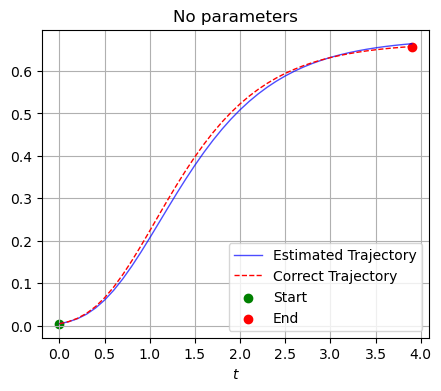

In [7]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'No parameters'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.005], [0.005], dim_x, dim_k, title=title, T_aux=4)

### Parameter $b$:

In [2]:
# Select ODE & settings:

ode_name = 'GompertzODE_par_b' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 25 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 1
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
lb = ode.init_low[0] + 0.001
for i in range(np.shape(X_list)[0]):
    for j in range(np.shape(X_list)[1]):
        if X_list[i][j] < 0:
            X_list[i][j] = lb
    #print(X_list[i])

# save data:
file_path = 'saved/data/gompertz_data_b.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)


(25, 80, 1) (25, 80, 1) (25, 80)
['X0', 'X1']


In [4]:
# additional building blocks -> running D-CODE:

building_blocks_lambda, function_names = D_CODE_simulation(ode_name, ode_param, x_id, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)

file_path = 'saved/building_blocks/gompertz_bb_b.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda, function_names), f)


Running with: ode_name=GompertzODE_par_b, ode_param=None, x_id=0, freq=10, n_sample=25, noise_sigma=0.01, seed=100, n_seed=1
(81, 25, 2)
(161, 25, 2)
Dataset shape:  (161, 25, 2)
Functions set:  {'neg': 1, 'mul': 1, 'log': 1, 'add': 1, 'sub': 1, 'div': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.79      2.40345e+16       20         0.143757         0.206371      1.19m
   1     9.02      9.08373e+11       20         0.150092         0.159909      1.12m
   2     6.16      7.71106e+07       11        0.0743409        0.0324935     48.32s
 
promising programs:
mul(pow(X0, 1.604), sub(div(1.295, X0), mul(1.332, X1)))
mul(pow(X0, 1.604), sub(div(1.295, X0), mul(1.332, X1)))
mul(pow(X0, 1.604), sub(div(1.295, X0), mul(1.332, X1)))
mul(pow(X0, 1.604),

In [5]:
# fit and evaluate models:

# upload data:
file_path = 'saved/data/gompertz_data_b.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

# upload building blocks:
file_path = 'saved/building_blocks/gompertz_bb_b.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)


# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(building_blocks_lambda)):

    # custom library with building blocks:
    custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[i]], function_names=[function_names[i]])
    
    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)

    # library:
    # print('')
    # print('library:')
    # library_terms = generalized_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:

    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 5 and lasso_penalty < 5:

        # enlarging initial range to test model robustness:
        # l = (ode.init_high - ode.init_low)/2 # print(l)
        # init_low = max(ode.init_low - l, 0)
        # init_high = ode.init_high + l #print(init_low, init_high)

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 25, ode.init_high, ode.init_low, dim_k)

        # final evaluation metric:
        alpha = 0.01 # regularization parameter
        error = mse + alpha * lasso_penalty
        print('error:', error)
    else:
        error = 1000
        print('')
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)


model:
(X0)' = 32904783408.261 1 + -1873266285.738 X0 + -3261509779.744 X1 + -2.082 X0^2 + -1.197 X0 X1 + 0.346 X1^2 + -25414181588.326 X0 1.2947410206015428/X0 + 1446827017.109 X0^2 1.2947410206015428/X0 + 2519044138.435 X0 X1 1.2947410206015428/X0

Too complex model


model:
(X0)' = 0.122 1 + 4.834 X0 + -0.056 X1 + 13.852 X0^2 + -0.204 X0 X1 + 0.006 X1^2 + -10.372 X0**1.6038245925152304 + -8.131 X0 X0**1.6038245925152304 + -3.208 X1 X0**1.6038245925152304 + 1.557 X0^2 X0**1.6038245925152304 + 1.096 X0 X1 X0**1.6038245925152304 + 0.504 X1^2 X0**1.6038245925152304

Too complex model


model:
(X0)' = -1.491 X0 log(X0*X1)
error: 0.014913897659476413


model:
(X0)' = 0.087 1 + 7.367 X0 + -0.011 X1 + 7.961 X0^2 + 2.156 X0 X1 + -0.010 X1^2 + -5.005 X0**1.1333117229121301 + -9.778 X0 X0**1.1333117229121301 + -4.925 X1 X0**1.1333117229121301 + 1.100 X0^2 X0**1.1333117229121301 + 0.662 X0 X1 X0**1.1333117229121301 + 0.397 X1^2 X0**1.1333117229121301

Too complex model


model:
(X0)' = 0.084 1

In [6]:
# Final model:

min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.1]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    idx = idxs[np.argmin(n_features_vec_2)]
else:
    idx = idxs[0]

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[idx]], function_names=[function_names[idx]])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('Final model:')
model.print()

Best building block:
['log(X0*X1)']

Final model:
(X0)' = -1.491 X0 log(X0*X1)


Best Model RMSE:  0.0011585281480424579


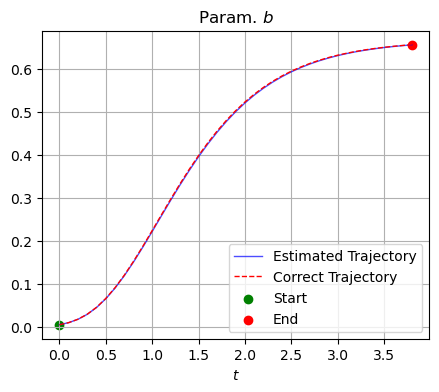

In [7]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'Param. $b$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.005, 1.5], [0.005, 1.5], dim_x, dim_k, title=title, T_aux=4)

### Parameters $a, b$:

In [2]:
# Select ODE & settings:

ode_name = 'GompertzODE_par_ab' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 25 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 1
dim_k = 2
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
lb = ode.init_low[0] + 0.001
for i in range(np.shape(X_list)[0]):
    for j in range(np.shape(X_list)[1]):
        if X_list[i][j] < 0:
            X_list[i][j] = lb
    #print(X_list[i])

# save data:
file_path = 'saved/data/gompertz_data_ab.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(25, 80, 1) (25, 80, 1) (25, 80, 2)
['X0', 'X1', 'X2']


In [4]:
# additional building blocks -> running D-CODE:

building_blocks_lambda, function_names = D_CODE_simulation(ode_name, ode_param, x_id, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)

file_path = 'saved/building_blocks/gompertz_bb_ab.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda, function_names), f)

Running with: ode_name=GompertzODE_par_ab, ode_param=None, x_id=0, freq=10, n_sample=25, noise_sigma=0.01, seed=100, n_seed=1
(81, 25, 3)
(161, 25, 3)
Dataset shape:  (161, 25, 3)
Functions set:  {'neg': 1, 'mul': 1, 'log': 1, 'add': 1, 'sub': 1, 'div': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.12      2.10896e+15       20          0.64517         0.550576      1.07m
   1     8.44      1.02204e+10       20         0.102578        0.0828515     52.65s
   2     5.59      1.43199e+07       17        0.0199735        0.0096223     40.06s
 
promising programs:
mul(div(add(X1, X1), neg(add(X0, X0))), mul(log(mul(X2, X0)), pow(X0, 1.971)))
mul(div(add(X1, X1), neg(add(X0, X0))), mul(log(mul(X2, X0)), pow(X0, 1.971)))
mul(div(add(X1, X1), neg(add(X0

In [6]:
# fit and evaluate models:

# upload data:
file_path = 'saved/data/gompertz_data_ab.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

# upload building blocks:
file_path = 'saved/building_blocks/gompertz_bb_ab.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)


# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(building_blocks_lambda)):

    # custom library with building blocks:
    custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[i]], function_names=[function_names[i]])

    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
    model.fit(X_list, t=dt, multiple_trajectories=True , u=param_list, x_dot=dX_list)

    # library:
    # print('')
    # print('library:')
    #library_terms = generalized_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)

    # model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:

    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 5 and lasso_penalty < 5:

        # enlarging initial range to test model robustness:
        # l = (ode.init_high - ode.init_low)/2 # print(l)
        # init_low = max(ode.init_low - l, 0)
        # init_high = ode.init_high + l #print(init_low, init_high)

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, ode.init_high, ode.init_low, dim_k)

        # final evaluation metric:
        alpha = 0.01 # regularization parameter
        error = mse + alpha * lasso_penalty
        print('error:', error)
    else:
        error = 1000
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)


model:
(X0)' = 0.584 X0 + -8.649 X0^2 + 1.628 X0 X1 + 6.118 X0**1.9709380822878872 + -0.680 X2 X0**1.9709380822878872 + 2.629 X0 X2 X0**1.9709380822878872 + -1.625 X1 X2 X0**1.9709380822878872
Too complex model


model:
(X0)' = -0.991 X0 X1 log(X0*X2)
error: 0.009909719708373942


model:
(X0)' = -0.027 1 + 1.493 X0 + 0.473 X1 + -1.524 X0^2 + 0.009 X0 X1 + -0.340 X0 X2 + -0.248 X1 X2 + 0.784 X0 X1**1.92786169577725 + -0.192 X2 X1**1.92786169577725 + -0.337 X0^2 X1**1.92786169577725 + -0.412 X0 X2 X1**1.92786169577725 + 0.126 X2^2 X1**1.92786169577725
Too complex model


model:
(X0)' = 0.352 1 + 0.082 X0 + 0.013 X2 + -1.294 X0^2 + 2.586 X0 X1 + 0.530 X1^2 + -0.740 X1 X2 + -0.393 X0 X1**1.2826715618698055 + -0.313 X1 X1**1.2826715618698055 + 0.110 X2 X1**1.2826715618698055 + -0.597 X0^2 X1**1.2826715618698055 + -0.749 X0 X2 X1**1.2826715618698055 + 0.188 X2^2 X1**1.2826715618698055
Too complex model


model:
(X0)' = -2.402 X0 + 0.398 X1 + -0.492 X2 + 2.632 X0^2 + -0.039 X0 X1 + 1.416 X0 

In [7]:
# Final model:

min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.1]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    idx = idxs[np.argmin(n_features_vec_2)]
else:
    idx = idxs[0]

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[idx]], function_names=[function_names[idx]])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('Final model:')
model.print()

Best building block:
['log(X0*X2)']

Final model:
(X0)' = -0.991 X0 X1 log(X0*X2)


Best Model RMSE:  0.0019690688644229035


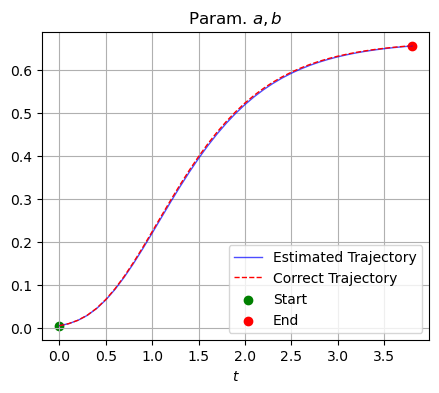

In [8]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'Param. $a, b$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.005, 1.5, 1.5], [0.005, 1.5, 1.5], dim_x, dim_k, title=title, T_aux=4)

Best Model 1 RMSE:  0.002332469627955473


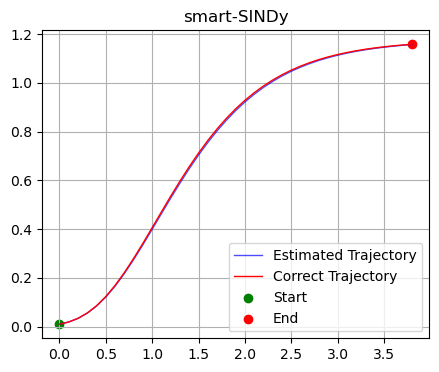

In [7]:
# robustness test:
init_point = [0.01, 1.5, 0.85]
n_sample = 3
rmse_ab_1, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, init_point, init_point, dim_k)
print('Best Model 1 RMSE: ', rmse_ab_1)
n_sample = 1
title = 'smart-SINDy'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, init_point, init_point, dim_x, dim_k, title=title, T_aux=4)

### Dev:

In [ ]:
# custom library with building blocks: 
custom_library = ps.CustomLibrary(library_functions=building_blocks_lambda, function_names=function_names)
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

library_terms = custom_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)

In [ ]:
# final library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=generalized_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

library_terms = generalized_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)

In [ ]:
# model: 
model.print()

In [ ]:
# custom library with building blocks: 
custom_library = ps.CustomLibrary(library_functions=building_blocks_lambda, function_names=function_names)
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)

library_terms = custom_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)

In [ ]:
# final library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=generalized_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)

library_terms = generalized_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)

In [ ]:
# model: 
model.print()

#### DEV:

In [ ]:
building_block_star = building_blocks_lambda[3]
print(building_block_star)

with open('gompertz_bb_star.pkl', 'wb') as f:
    dill.dump((building_block_star), f)

In [ ]:
import pickle
with open('gompertz_bb_star.pkl', 'wb') as f:
    pickle.dump(building_block_star, f)

In [ ]:
import tensorflow as tf

# Define the shape of the array
num_time_points = 100
num_state_variables = 1

# Create a 2D TensorFlow array with the specified shape and ensure state values are positive
z = tf.random.uniform([num_time_points, num_state_variables], minval=0, maxval=1)

print(z)

In [ ]:
building_block_star(z)